# Concatenation Model

## Install Prerequsities

In [ ]:
! pip install virtualenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 4.9 MB/s 
     |████████████████████████████████| 468 kB 92.7 MB/s 


In [ ]:
! virtualenv env

created virtual environment CPython3.8.16.final.0-64 in 398ms
  creator CPython3Posix(dest=/content/env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==22.3.1, setuptools==65.6.3, wheel==0.38.4
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
! source env/bin/activate

In [ ]:
!pip install transformers[tf-cpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 7.6 MB 95.9 MB/s 
     |████████████████████████████████| 182 kB 91.9 MB/s 
     |████████████████████████████████| 5.8 MB 83.7 MB/s 
     |████████████████████████████████| 214.5 MB 79 kB/s 
     |████████████████████████████████| 151 kB 105.6 MB/s 
     |████████████████████████████████| 442 kB 99.4 MB/s 
     |████████████████████████████████| 83 kB 3.3 MB/s 
     |████████████████████████████████| 5.9 MB 88.9 MB/s 
     |████████████████████████████████| 1.7 MB 86.1 MB/s 
     |████████████████████████████████| 438 kB 95.4 MB/s 
     |████████████████████████████████| 13.1 MB 96.4 MB/s 
     |████████████████████████████████| 588.3 MB 24 kB/s 
     |████████████████████████████████| 578.1 MB 9.0 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version i

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 91.1 MB/s 
     |████████████████████████████████| 132 kB 80.2 MB/s 
     |████████████████████████████████| 127 kB 91.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install tensorflow-gpu==2.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.1 MB 7.4 kB/s 


## Load Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers as tr
import PIL as PIL
from PIL import ImageFile
import os


import datetime
import datasets

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pandas as pd
import numpy as np
#metadata
metadata = pd.read_csv('/content/drive/MyDrive/Github/ece539-metamushroom-project/data/DF20M-train_metadata_PROD_edibility.csv')
sample = metadata[['image_path', 'edibility', 'month', 'Substrate', 'Habitat', 'species']].dropna()
DATA_DIR = '/content/drive/MyDrive/Github/ece539-metamushroom-project/data/images/DF20M/'


## Loading and Partitioning

In [ ]:
from sklearn.model_selection import train_test_split

Xs = sample[['image_path', 'edibility', 'month', 'Substrate', 'Habitat']]
ys = sample[['species']]

Xs_, Xs_test, ys_, ys_test = train_test_split(Xs, ys, test_size=0.2, stratify = ys, random_state=42)
Xs_train, Xs_sample, ys_train, ys_sample = train_test_split(Xs_, ys_, test_size = 0.8, stratify = ys_, random_state = 42)
Xstr, Xste, ystr, yste = train_test_split(Xs_train, ys_train, test_size = 0.2, stratify = ys_train, random_state = 42)

In [ ]:
len(Xstr), len(Xste)

(4161, 1041)

In [ ]:
month = tf.keras.utils.to_categorical(Xstr['month'].factorize()[0], num_classes = 12)
substrate = tf.keras.utils.to_categorical(Xstr['Substrate'].factorize()[0], num_classes = 32)
habitat = tf.keras.utils.to_categorical(Xstr['Habitat'].factorize()[0], num_classes = 32)

month_test = tf.keras.utils.to_categorical(Xste['month'].factorize()[0], num_classes = 12)
substrate_test = tf.keras.utils.to_categorical(Xste['Substrate'].factorize()[0], num_classes = 32)
habitat_test = tf.keras.utils.to_categorical(Xste['Habitat'].factorize()[0], num_classes = 32)


In [ ]:
Xstr['month'] = month.tolist()
Xstr['Substrate'] = substrate.tolist()
Xstr['Habitat'] = habitat.tolist()

In [ ]:
Xste['month'] = month_test.tolist()
Xste['Substrate'] = substrate_test.tolist()
Xste['Habitat'] = habitat_test.tolist()

## Preprocessing

In [ ]:
sample = Xste

In [ ]:
features=datasets.Features({
                      "img": datasets.Image(),
                      "habitat": datasets.features.Sequence(datasets.Value("float32"), length = 32),
                      "month":datasets.features.Sequence(datasets.Value("float32"), length = 12),
                      "substrate":datasets.features.Sequence(datasets.Value("float32"), length = 32),
                      "label": datasets.features.ClassLabel(names=['edible', 'inedible']),
                  })

ds = datasets.Dataset.from_dict({"img":list(sample['image_path']),
                                 "habitat": list(sample['Habitat']),
                                 "month": list(sample['month']),
                                 "substrate": list(sample['Substrate']), 
                                 "label":list(sample['edibility'])},
                                features = features)
# we are also renaming our label col to labels to use `.to_tf_dataset` later
ds = ds.rename_column("label", "labels")

    features=datasets.Features({
                          "img": datasets.Image(),
                          "habitat": datasets.features.Value('float'),
                          "month":datasets.features.Value('float'),
                          "substrate":datasets.features.Value('float'),
                          "label": datasets.features.ClassLabel(names=['edible', 'inedible']),
                      })
    ds = datasets.Dataset.from_dict({"img":list(sample['image_path']), 
                                    "habitat": list(sample['Habitat'].factorize()[0]),
                                    "month": list(sample['month']),
                                    "substrate": list(sample['Substrate'].factorize()[0]),
                                    "label":list(sample['edibility'])},
                                    features=features)
    # we are also renaming our label col to labels to use `.to_tf_dataset` later
    ds = ds.rename_column("label", "labels")

In [ ]:
from transformers import ViTFeatureExtractor
from tensorflow import keras 
from tensorflow.keras import layers

model_id = 'google/vit-base-patch16-224'

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)


# basic processing (only resizing)
def process(examples):
    examples.update(feature_extractor(examples['img'], return_tensors='tf'))
    return examples



Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
os.chdir(DATA_DIR)

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
#processed_dataset = ds.map(process, batched=True, batch_size = 200)
#processed_dataset.save_to_disk("/content/drive/MyDrive/Github/ece539-metamushroom-project/data/processed_datasetXste_corr")

In [ ]:
processed_dataset = datasets.load_from_disk("/content/drive/MyDrive/Github/ece539-metamushroom-project/data/processed_datasetXstr_corr")
processed_dataset_test = datasets.load_from_disk("/content/drive/MyDrive/Github/ece539-metamushroom-project/data/processed_datasetXste_corr")

In [ ]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")
train_batch_size = 32


tf_test_dataset = processed_dataset_test.to_tf_dataset(
  columns=['pixel_values', 'month', 'substrate', 'habitat'],
  label_cols=["labels"],
  shuffle=False,
  batch_size=train_batch_size,
  collate_fn=data_collator)

In [ ]:
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

In [ ]:
data = processed_dataset.shuffle().train_test_split(test_size=.15)

In [ ]:
img_class_labels = data['train'].features["labels"].names

In [ ]:
id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 20
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5

In [ ]:
id2label

{'0': 'edible', '1': 'inedible'}

In [ ]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = data["train"].to_tf_dataset(
  columns=['pixel_values', 'month', 'substrate', 'habitat'],
  label_cols=["labels"],
  shuffle=True,
  batch_size=train_batch_size,
  collate_fn=data_collator)

# converting our validation dataset to tf.data.Dataset
tf_val_dataset = data["test"].to_tf_dataset(
  columns=['pixel_values','month', 'substrate', 'habitat'],
  label_cols=["labels"],
  shuffle=True,
  batch_size=eval_batch_size,
  collate_fn=data_collator)

## Model Architecture and Training

In [ ]:
# alternatively create Image Classification model using Keras Layer and ViTModel 
# here you can also add the processing layers of keras

# import tensorflow as tf
from transformers import TFViTModel

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# inputs
pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')
data_augmentation = tf.keras.models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2),
     
    ],
    name="data_augmentation",
)

month = tf.keras.layers.Input(shape=(12,), name='month', dtype='float32')
habitat = tf.keras.layers.Input(shape=(32,), name='habitat', dtype='float32')
substrate = tf.keras.layers.Input(shape=(32,), name='substrate', dtype='float32')



# # model layer
vit = base_model.vit(data_augmentation(pixel_values))[0]
concat = tf.keras.layers.Concatenate()([vit[:, 0, :], month, habitat, substrate])
dense_layer = tf.keras.layers.Dense(100, activation='relu', name='dense_1')(concat)
dense_layer_2 =  tf.keras.layers.Dense(100, activation='relu', name='dense_2')(dense_layer)
dense_layer_3 =  tf.keras.layers.Dense(50, activation='relu', name='dense_3')(dense_layer_2)
dense_layer_4 =  tf.keras.layers.Dense(20, activation='relu', name='dense_4')(dense_layer_3)
classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(dense_layer_4)

#classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(vit[:, 0, :])

# # model
keras_model = tf.keras.Model(inputs=[pixel_values, month, habitat, substrate], outputs=classifier)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
optimizer = optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)

# define loss
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)
loss_2 = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True)

# define metrics 
metrics=[
    tf.keras.metrics.BinaryAccuracy(name="accuracy"), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve

]

keras_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

In [ ]:
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pixel_values (InputLayer)      [(None, 3, 224, 224  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 3, 224, 224)  0          ['pixel_values[0][0]']           
                                                                                                  
 vit (TFViTMainLayer)           TFBaseModelOutputWi  86389248    ['data_augmentation[0][0]']      
                                thPooling(last_hidd                                               
                                en_state=(None, 197                                           

In [ ]:
#evaluate before training
with tf.device('/GPU:0'):
  test_results = keras_model.evaluate(tf_test_dataset)

33/33 [==============================] - 76s 2s/step - loss: 0.6728 - accuracy: 0.7397 - tp: 5.0000 - fp: 19.0000 - tn: 765.0000 - fn: 252.0000 - precision: 0.2083 - recall: 0.0195 - auc: 0.5398 - prc: 0.2625


In [ ]:
import os
import transformers.keras_callbacks 


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='Xstr_corrmodel.{epoch:02d}-{val_loss:.2f}.h5')
]

In [ ]:
tf.debugging.set_log_device_placement(True)


In [ ]:
# Place tensors on the GPU
with tf.device('/GPU:0'):
  train_results = keras_model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs)

Epoch 1/20


111/111 [==============================] - 422s 4s/step - loss: 0.5534 - accuracy: 0.7545 - tp: 1.0000 - fp: 2.0000 - tn: 2667.0000 - fn: 866.0000 - precision: 0.3333 - recall: 0.0012 - auc: 0.5811 - prc: 0.2811 - val_loss: 0.5240 - val_accuracy: 0.7408 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 463.0000 - val_fn: 162.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7642 - val_prc: 0.5419
Epoch 2/20
111/111 [==============================] - 391s 4s/step - loss: 0.5063 - accuracy: 0.7548 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2669.0000 - fn: 867.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7108 - prc: 0.4190 - val_loss: 0.5224 - val_accuracy: 0.7408 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 463.0000 - val_fn: 162.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7701 - val_prc: 0.5525
Epoch 3/20
111/111 [==============================] - 391s 4s/step - loss: 0.4541 - accuracy: 0.7650 - tp: 108.0000 - fp: 72.00

In [ ]:
def f1(precision, recall):
  return 2*(precision*recall)/(precision + recall)

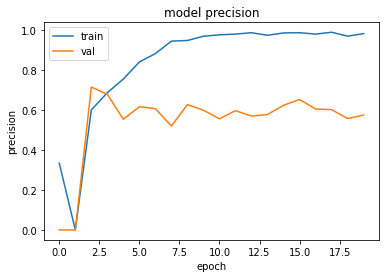

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_results.history['precision'])
plt.plot(train_results.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

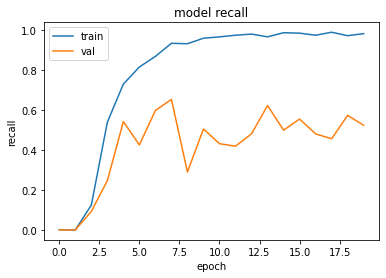

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_results.history['recall'])
plt.plot(train_results.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

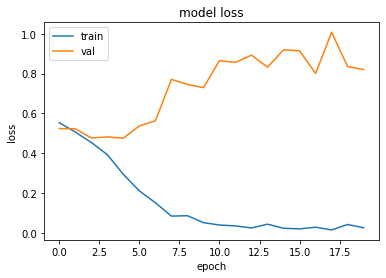

In [ ]:
plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

In [ ]:
keras_model.load_weights('Xstr_corrmodel.07-0.56.h5') #best - 7th epoch

In [ ]:
with tf.device('/GPU:0'):
  test_pred = keras_model.predict(tf_test_dataset)

33/33 [==============================] - 122s 3s/step


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = tf.greater(test_pred, .5)
confusion_matrix(y_true, y_pred)

array([[676, 108],
       [142, 115]])

In [ ]:
y_true.shape, y_pred.shape

In [ ]:
556+228+176+81    

In [ ]:
#tp: 136.0000 - fp: 173.0000 - tn: 611.0000 - fn: 121.0000
#tp: 136.0000 - fp: 173.0000 - tn: 611.0000 - fn: 121.0000

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, test_pred, pos_label=1)

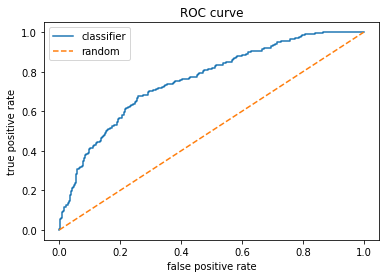

In [ ]:
from matplotlib import pyplot as plt

plt.plot(fpr, tpr, label = 'classifier')
plt.plot(fpr, fpr, '--', label = 'random')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, test_pred, pos_label=1)

In [ ]:
thresholds[750:760]

In [ ]:
precision[750:760]

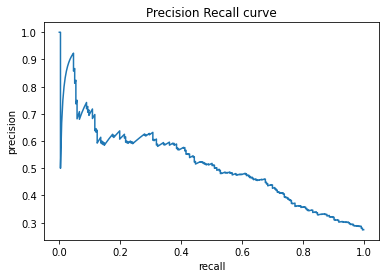

In [ ]:
from matplotlib import pyplot as plt

plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision Recall curve")
plt.show()

In [ ]:
with tf.device('/GPU:0'):
  test_results = keras_model.evaluate(tf_test_dataset, batch_size = 1041)

33/33 [==============================] - 62s 2s/step - loss: 0.6279 - accuracy: 0.7598 - tp: 115.0000 - fp: 108.0000 - tn: 676.0000 - fn: 142.0000 - precision: 0.5157 - recall: 0.4475 - auc: 0.7570 - prc: 0.5159


In [ ]:
f1(0.4401, 0.5292)